In [10]:
import os
import tensorflow as tf
import cv2
import numpy as np
import time
import inspect
from sklearn.cross_validation import KFold
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filelabel = np.load('filelabel.npy')
data = np.load('data128.npy')
cat_labels = np.load('cat_labels.npy')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(data, cat_labels, test_size = 0.2, stratify=filelabel)

In [4]:
batch_size = 32
num_classes = 103
epochs = 100
img_rows, img_cols, dim = 128, 128, 3
input_shape = (img_rows, img_cols, dim)
nfolds = 5

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    shear_range = 0.2,
    rotation_range = 20,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    horizontal_flip = True
)
train_datagen.fit(X_train)

In [5]:
def get_model():
    base_model = VGG16(include_top=False, input_shape=input_shape)
    for layers in base_model.layers:
        layers.trainable = False
    base_model_output = base_model.output
    
    #Adding new layers
    x = Flatten()(base_model.output)
    x = Dense(500, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax', name='fc2')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

## First just checking for the scope of this method using a simple model fitting

In [7]:
model = get_model()

In [8]:
valid_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    shear_range = 0.2,
    rotation_range = 20,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    horizontal_flip = True
)
valid_datagen.fit(X_test)

In [9]:
opt = Adam(lr=1e-3, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [1]:
model.fit_generator(train_datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=len(X_train)//32, epochs=epochs,
                   validation_data=valid_datagen.flow(X_test, y_test, batch_size=32),
                   validation_steps=len(X_test)//32)

NameError: name 'model' is not defined

## Finding the optimum parameters using Cross Validation

In [7]:
folds = KFold(len(y_train), n_folds = nfolds, shuffle = True, random_state = 111)
vallogger = []
trlogger = []
tracc = []
valacc = []
for num, (inTr, inVa) in enumerate(folds):
    xtr = X_train[inTr]
    xva = X_train[inVa]
    ytr = y_train[inTr]
    yva = y_train[inVa]
    model = get_model()
    opt = Adam(lr=1e-3, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    train_datagen = ImageDataGenerator(
        rescale = 1.0/255,
        shear_range = 0.2,
        rotation_range = 20,
        width_shift_range = 0.2, 
        height_shift_range = 0.2, 
        horizontal_flip = True
    )
    train_datagen.fit(xtr)
    valid_datagen = ImageDataGenerator(
        rescale = 1.0/255,
        shear_range = 0.2,
        rotation_range = 20,
        width_shift_range = 0.2, 
        height_shift_range = 0.2, 
        horizontal_flip = True
    )
    valid_datagen.fit(xva)
    history = model.fit_generator(train_datagen.flow(xtr, ytr, batch_size=32),
                   steps_per_epoch=len(xtr)//32, epochs=1,
                   validation_data=valid_datagen.flow(xva, yva, batch_size=32),
                   validation_steps=len(xva)//32)    
    vallogger.append(history.history['val_loss'])
    trlogger.append(history.history['loss'])
    tracc.append(history.history['acc'])
    valacc.append(history.history['val_acc'])
    print('Done fold ' + str(num) + ': Train Metric - ', model.evaluate(xtr, ytr), ' Val - ',\
          model.evaluate(xva, yva))
    
vallogger = np.array(vallogger)
trlogger = np.array(trlogger)
valacc = np.array(valacc)
tracc = np.array(tracc)

Epoch 1/1
1311/1311 [==============================] - 11s 8ms/step
Done fold 0: Train Metric -  [11.664735575668685, 0.20190839696931476]  Val -  [12.12352793058487, 0.1754385963775655]
Epoch 1/1
1310/1310 [==============================] - 11s 8ms/step
Done fold 1: Train Metric -  [11.721539786880513, 0.17553901925833712]  Val -  [12.116435436802057, 0.16793893141145924]
Epoch 1/1
1310/1310 [==============================] - 9s 7ms/step
Done fold 2: Train Metric -  [12.266595338596867, 0.1722953634674575]  Val -  [12.209202144710162, 0.17251908403771524]
Epoch 1/1
1310/1310 [==============================] - 9s 7ms/step
Done fold 3: Train Metric -  [12.06446538884047, 0.16809769126749566]  Val -  [12.498611048341708, 0.146564885530308]
Epoch 1/1
1310/1310 [==============================] - 9s 7ms/step
Done fold 4: Train Metric -  [12.464232957356305, 0.1505437893403825]  Val -  [12.733045460067633, 0.13511450397604294]


In [8]:
val_acc, val_loss, tr_acc, tr_loss = [], [], [], []
for j in range(epochs):
    acc, loss, val_ac, val_l = 0, 0, 0, 0
    for i in range(nfolds):
        acc += tracc[i][j]
        loss += trlogger[i][j]
        val_ac += vallogger[i][j]
        val_l += valacc[i][j]
    val_acc.append(1.0*val_ac/nfolds)
    val_loss.append(1.0*val_l/nfolds)
    tr_acc.append(1.0*acc/nfolds)
    tr_loss.append(1.0*loss/nfolds)

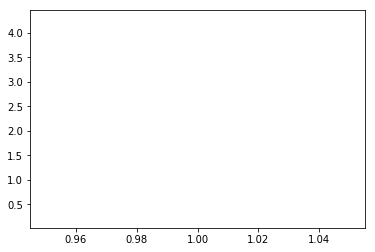

In [12]:
plt.plot(range(1, epochs + 1), val_loss)
plt.plot(range(1, epochs + 1), tr_loss)

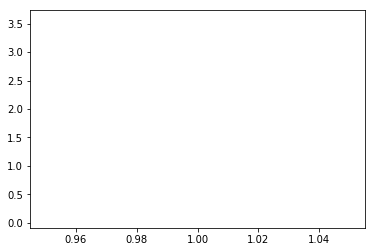

In [13]:
plt.plot(range(1, epochs + 1), val_acc)
plt.plot(range(1, epochs + 1), tr_acc)